<a href="https://colab.research.google.com/github/der-himmel/obr-iz/blob/main/obr_iz_pz3" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка нужных зависимостей

In [38]:
!pip install opencv-python

!pip install numpy

!pip install matplotlib

# Импортируем библиотеки

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io

In [40]:
image_height = 150
image_width = 150
dpi = 100

In [48]:
urls = [
    # f"https://evivid.ru/vk/img.php?url=https%3A%2F%2Fsun9-40.userapi.com%2Fimpg%2FCNGYtv5mZs4rONGMJx0crZ6-ajN_8sbPFP93wA%2FONDINN4x9aQ.jpg%3Fsize%3D429x604%26quality%3D96%26sign%3D701e7d60fa1fea0d6207e0a422c9d7eb%26c_uniq_tag%3DZESB4zRepXZuywLbaczntiMWkgX5Uiovn25WomRgztY%26type%3Dalbum",
    f"https://cdn.frankerfacez.com/emoticon/391932/4"
    ]

In [42]:
images = list()

for url in urls:
    image = io.imread(url)
    images.append(image)

In [49]:
def show_image(image: np.ndarray, dpi: int) -> None:
    image_height, image_width, _ = image.shape
    plt.figure(
        figsize=(
            image_width / float(dpi),
            image_height / float(dpi)
        )
    )
    plt.imshow(image)
    plt.axis('off')
    plt.show()

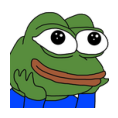

In [51]:
img = images[0]
show_image(img, dpi)

## Ближайшие соседи (Neares Neighbour)

In [52]:
def nearest_neighbour_interpolation(image: np.ndarray, scale_factor: float) -> np.ndarray:
    original_height, original_width, channels = image.shape
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    resized = np.zeros((new_height, new_width, channels), dtype=image.dtype)

    height_ratio = original_height / new_height
    width_ratio = original_width / new_width

    for i in range(new_height):
        for j in range(new_width):
            original_x = int(j * width_ratio)
            original_y = int(i * height_ratio)
            resized[i, j] = image[original_y, original_x]

    return resized

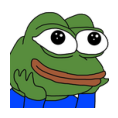

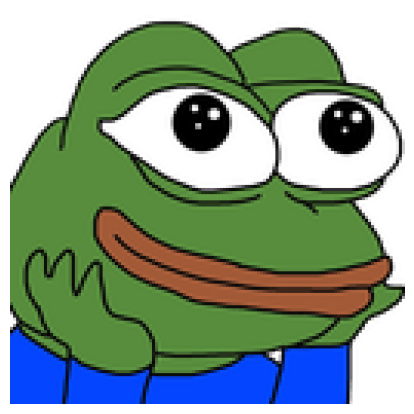

In [53]:
nearest_resized = nearest_neighbour_interpolation(img, scale_factor=4.0)
nearest_resized_low = nearest_neighbour_interpolation(img, scale_factor=0.5)

show_image(img, dpi)
show_image(nearest_resized, dpi)

## Билинейная интерполяция (Bilinear interpolation)

In [46]:
def bilinear_interpolation():
    return

## Бикубическая интерполяция (Bicubic Interpolation)